### Imports 

In [66]:
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Layer, Input, Lambda, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, Dropout, Dense, GlobalAveragePooling1D, Softmax, Flatten
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.utils import resample
from random import randint
import itertools

# Explorando o Dataset

• N: Normal beat - 0

• S: Supraventricular premature beat - 1

• V: Premature ventricular contraction - 2

• F: Fusion of ventricular and normal beat - 3

• Q: Unclassifiable beat - 4

## Reading the Dataset

In [61]:
# Load the dataset with pandas
train_df = pd.read_csv('dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('dataset/mitbih_test.csv', header=None)

In [53]:
if True not in train_df.isna(): print("Dataset without NaN")

Dataset without NaN


In [54]:
if True not in test_df.isna(): print("Dataset without NaN")

Dataset without NaN


In [50]:
yValues = train_df[187].value_counts()
yValues

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

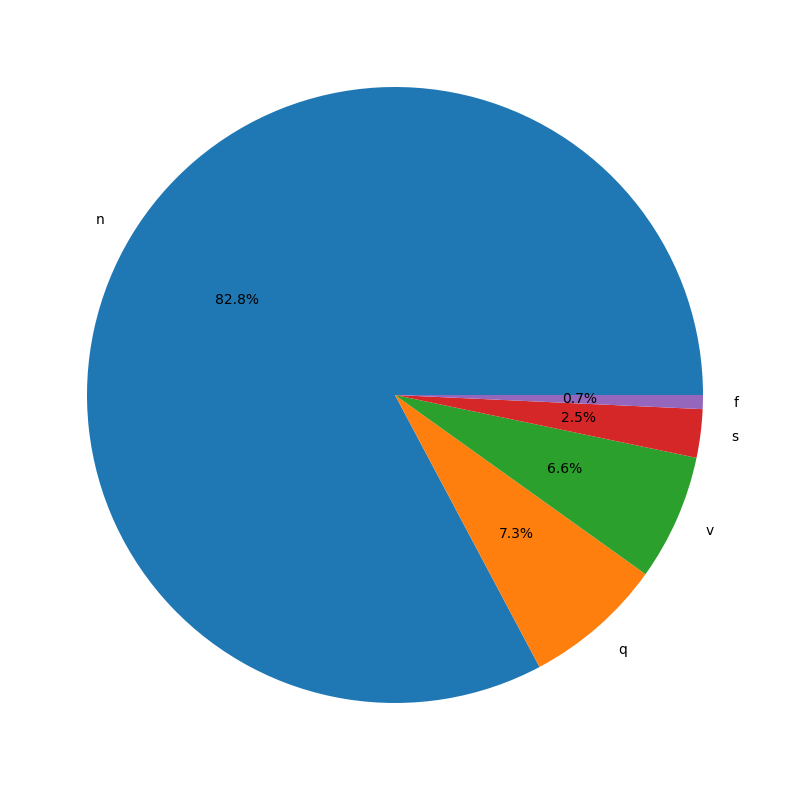

In [60]:
plt.figure(figsize=(20,10))
plt.pie(yValues, labels=['n','q','v','s','f'], autopct='%1.1f%%')
plt.show()

<AxesSubplot: xlabel='187', ylabel='count'>

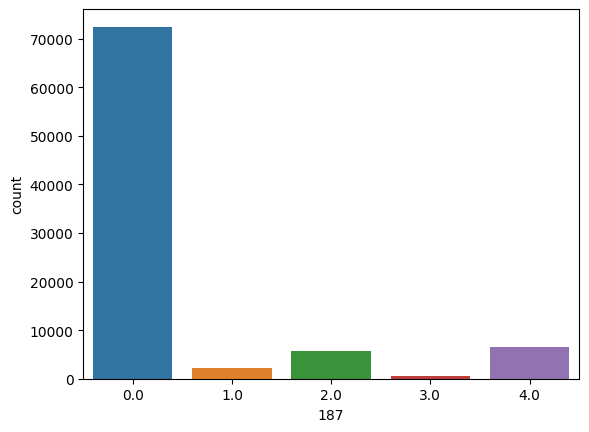

In [65]:
sns.countplot(x=187, data = train_df) 

### Interpreting the graph

It can be seen that our dataset has the samples corresponding to each category in an unbalanced way. Around 82.8% of our samples have a normal heartbeat, while only a very small portion represents abnormal heartbeats. To avoid bias in our data, we will use resample to pre-process our data.

In [76]:
# Do a resample in all categories from 1 to 4
dfs = [resample(train_df[train_df[187] == i], replace = True, n_samples = 20000, random_state = randint(130, 150)) for i in range(0, 5)]

train_df_sampled = pd.concat(dfs)

yValues_sampled = train_df_sampled[187].value_counts()
yValues_sampled

0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: 187, dtype: int64

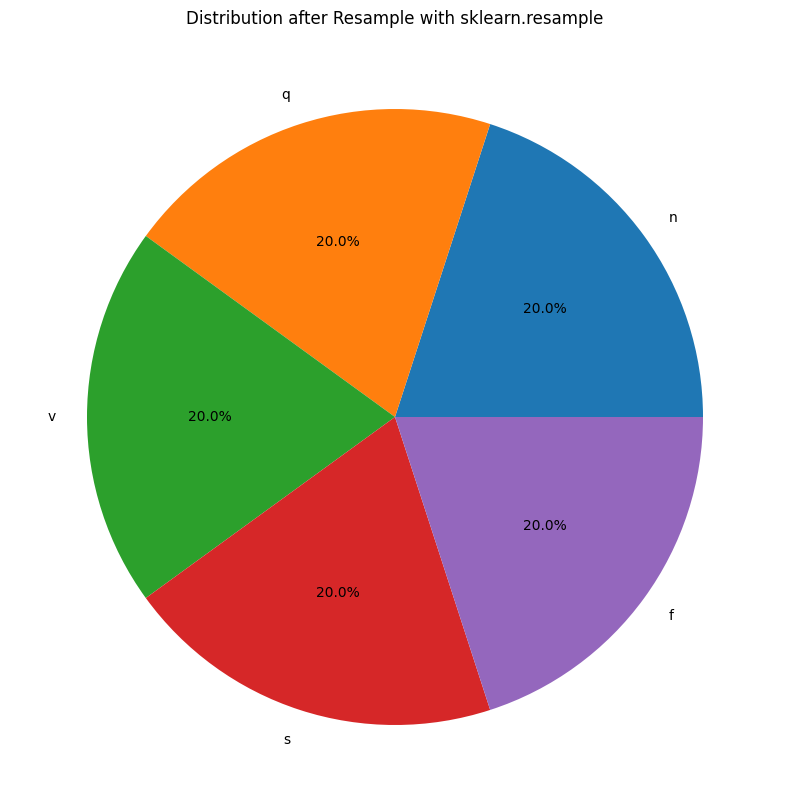

In [80]:
plt.figure(figsize=(20,10))
plt.pie(yValues_sampled, labels=['n','q','v','s','f'], autopct='%1.1f%%')
plt.title('Distribution after Resample with sklearn.resample')
plt.show()

Now that our dataset is balanced, let's explore more about each category. We will take one random sample from each category

In [82]:
unique_c_sample = train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
unique_c_sample

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
45122,1.000000,0.764706,0.036053,0.047438,0.055028,0.079696,0.136622,0.123340,0.140417,0.129032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73496,0.925831,0.744246,0.135550,0.079284,0.173913,0.255754,0.265985,0.289003,0.291560,0.301790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76061,1.000000,0.984724,0.810811,0.497062,0.415981,0.379553,0.352526,0.325499,0.317274,0.305523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80918,1.000000,0.806540,0.564033,0.316076,0.189373,0.208447,0.196185,0.173025,0.152589,0.147139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
85870,1.000000,0.819355,0.474194,0.261290,0.119355,0.090323,0.093548,0.093548,0.090323,0.096774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


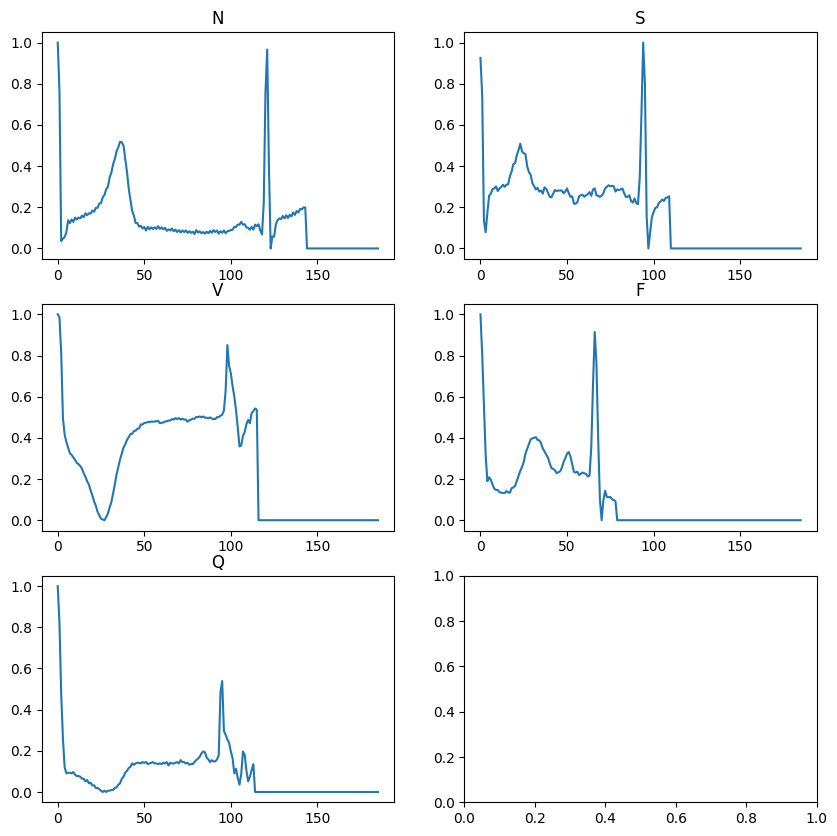

In [89]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0][0].plot(unique_c_sample.iloc[0,:186])
ax[0][1].plot(unique_c_sample.iloc[1,:186])
ax[1][0].plot(unique_c_sample.iloc[2,:186])
ax[1][1].plot(unique_c_sample.iloc[3,:186])
ax[2][0].plot(unique_c_sample.iloc[4,:186])

ax[0][0].set_title("N")
ax[0][1].set_title("S")
ax[1][0].set_title("V")
ax[1][1].set_title("F")
ax[2][0].set_title("Q")

plt.show()

I'm not an expert on ECG, so it's hard to give a meaningful insight about this plots, but is interesting to see that 3/4 of anormal beats has quick and prolonged decrease of signal. Further investigation is needed. 

We intend to add some meaningful noise to our dataset, so we could generalize our CNN to noisy ECG's

# Building our CNN model with ResNet

To build our Convolutional Neural Network, we will use Keras (a library based on TensorFlow). The architeture of CNN ResNet is given by:

Input -> Conv1D|BN|ReLU -> Conv1D|BN|ReLu|Dropout|Conv1D -> Residual Block * n -> BN|ReLu|Dense|softmax

In [90]:
# Separating the features from the outputs
X_train = train_df_sampled.iloc[:, :-1].values  
y_train = train_df_sampled.iloc[:, -1].values  

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

categories = train_df[187].unique()

# Transforma o output em variáveis categóricas
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Making the Residual Block

In [97]:
def bloco_residual(x, filters, kernel_size=16, stride=1):
    
    # Caminho principal
    shortcut = x  # salva a entrada para a conexão residual

    # Primeira subcamada
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)

    # Segunda subcamada
    x = BatchNormalization()(x)
    x = ReLU()(x)
    X = Dropout(0.5)(x)
    x = Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)

    # Conexão residual
    if x.shape[-1] != shortcut.shape[-1] or stride != 1:
        # Ajusta a dimensão do canal e tamanho se stride > 1
        shortcut = Conv1D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)

    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_classes, num_blocks, num_filters):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=1, padding='same', use_bias=False)(inputs)  # Initial adjust to 
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Add Residual Block
    for i in range(num_blocks):
        stride = 2 if i % 2 == 0 else 1  # Apply stride to each second block
        x = residual_block(x, num_filters, stride=stride)
        num_filters *= 2  # Double the filter number

    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, validation_data, epochs = 10):
    
    history = model.fit(X_train, y_train, epochs = epochs, validation_data=validation_data)
    
    return (model, history)

def evaluate_model(history, X_test, y_test,model):
    
    scores = model.evaluate((X_test), y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [93]:
model3 = build_model((187, 1), 5, 4, 16)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_60 (Conv1D)             (None, 187, 64)      448         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_47 (BatchN  (None, 187, 64)     256         ['conv1d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_47 (ReLU)                (None, 187, 64)      0           ['batch_normalization_47[0]

In [ ]:
model3_fit = train_model(model3, X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3125/3125 [==============================] - 652s 207ms/step - loss: 0.3148 - accuracy: 0.8923 - val_loss: 0.1544 - val_accuracy: 0.9486
Epoch 2/10
3125/3125 [==============================] - 656s 210ms/step - loss: 0.1213 - accuracy: 0.9583 - val_loss: 0.1847 - val_accuracy: 0.9401
Epoch 3/10
3125/3125 [==============================] - 760s 243ms/step - loss: 0.0838 - accuracy: 0.9719 - val_loss: 0.1619 - val_accuracy: 0.9472
Epoch 4/10
  74/3125 [..............................] - ETA: 10:30 - loss: 0.0622 - accuracy: 0.9814